# Meshing and surface registration

 1. Mesh the surfaces (and insides) of both prostate masks (MR and US)
 1. Perform Coherent Point Drift (CPD) registration on the vertices
 1. Interpolate the displacement field within the prostate:
     - Linearly (to create some sort of benchmark to compare other possibilities against)
     - Non-linearly (kernel-based interpolation)
     - Use Finite Element Method (FEM) to simulate the behaviour of the internal points, when given surface displacements as boundary conditions. This requires installation of FeBIO

### Notes on interactive plotting of meshes

When this Notebook was developed, `pyvista` was not working for interactive plotting, and `itkwidgets` were unable to load any saved meshes. Any of the two libraries would be enough on their own, but due to these problems, I needed to use `pyvista` to load the meshes, and then use `itkwidgets` for plotting. 

Also, `itkwidgets` does not support Jupyter Lab 3 at the momment, so **only Jupyter Notebook is supported**

### Load required libraries

In [1]:
%load_ext autoreload
%autoreload 2

#Import basic libraries
import numpy as np, pandas as pd, sys, os, glob, matplotlib.pyplot as plt, SimpleITK as sitk
from mpl_toolkits import mplot3d
from collections import OrderedDict
from tqdm import tqdm
from functools import partial

#Import mesh plotting / manipulation libraries
#For interactive plotting, pyvista requires: ipyvtklink, pythreejs
from itkwidgets import view
import pygalmesh
import pyvista as pv
import meshio
import copy
import open3d as o3
from probreg import cpd

#import plot_lib
from pathlib import Path
sys.path.append(os.path.join(Path.home(), 'plot_lib'))
from plot_lib import plot, plot_multi_mask, plot_alpha

#Custom functions
from lib.processing.preprocessing import (  surface_distance_metrics, MI_sitk, DSC_sitk, print_metric,
                                            load_json, save_json, timer, make_dirs, dump, get_gradient_features,
                                            transform_sitk, point_average_error, sitk_transform_points,
                                            point_max_min_distance, point_hd95, read_fiducials, get_ur_points)
from lib.processing.meshing import get_surface_mesh, quality, get_DDF, get_FEM_displacements, PlotCallback

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Global configuration

In [2]:
#Paths
PATH_OUT= './registration_data/preprocessed'
PATH_MASKS= './registration_data/meshes'
PATH_DDF= './registration_data/DDFs'
PATH_FID= './registration_data/fiducials'
make_dirs(PATH_MASKS, PATH_DDF)

#Meshing config
PLOT= True #Show plots
SPACING= [0.5]*3 #Input spacing of the masks to mesh
MESH_MR= True #Should we mesh the MR masks?
MESH_US= True #Should we mesh the US masks?
QUICK_MODE= True #Much quicker meshing (but not as smooth)

#Registration config
USE_CUDA= True #Use CUDA for CPD registration (much faster)
SAVE= True #Should we save the outputs?
REGISTER_RIGID= True #Perform rigid CPD registration before non-rigid (better True)
USE_FEM= True #Interpolate internal displacement field using FEM (requires FeBIO)
fem_material= dict(material='neo-Hookean', density=str(1.), E=str(5000.), v=str(0.49)) #FEM material properties

#Meshing configuration
meshing_configuration= dict(voxel_size= SPACING, max_facet_distance=2., max_cell_circumradius=1.,
                            lloyd= not QUICK_MODE, #Gloabal outside lerp
                            odt= not QUICK_MODE, #Global inside lerp
                            perturb= True, exude= True, #local
                            max_edge_size_at_feature_edges= 0.0, min_facet_angle= 0.0,
                            max_radius_surface_delaunay_ball= 0.0,
                            max_circumradius_edge_ratio= 0., verbose= False)

#Use CUDA for CPD speedup?
if USE_CUDA:
    import cupy as cp
    to_cpu, to_array, float32 = cp.asnumpy, cp.asarray, cp.float32
    to_numpy= lambda a: to_array(to_cpu(a)).get()
else:
    to_cpu, to_array, float32= lambda x: x, np.asarray, np.float32
    to_numpy= lambda a: a

#CPD + interpolation configuration. Defined as a list for doing a hyperparameter sweep
betas, lambdas, all_kernels, epsilons= [100.], [3.3], ['thin_plate_spline'], [100.]

#Create dataframe with results. Useful if we do a hyperparameter sweep
columns= ['beta', 'lambda', 'kernel', 'epsilon', 'mi_all', 'mi_in', 
          'mig_all', 'mig_in','dsc', 'hd95', 'abd', 'tre']

#Statistics
mr_tris, mr_tetras, mr_surface_vertices= [], [], []
us_tris, us_tetras, us_surface_vertices= [], [], []

#PIDs
pids= sorted([img.split('_')[0] for img in os.listdir(PATH_OUT) if img.endswith('MR_img.nrrd')], 
             key= lambda a: int(a.split('ID')[1]))
print('PIDs:', pids)

PIDs: ['ID0001', 'ID0002']


### Meshing + CPD + FEM / Interpolation $\rightarrow$ DDF generation

ID0001
ID0001
 - Original DSC: 0.8564


interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

Empty DataFrame
Columns: [beta, lambda, kernel, epsilon, mi_all, mi_in, mig_all, mig_in, dsc, hd95, abd, tre]
Index: []


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

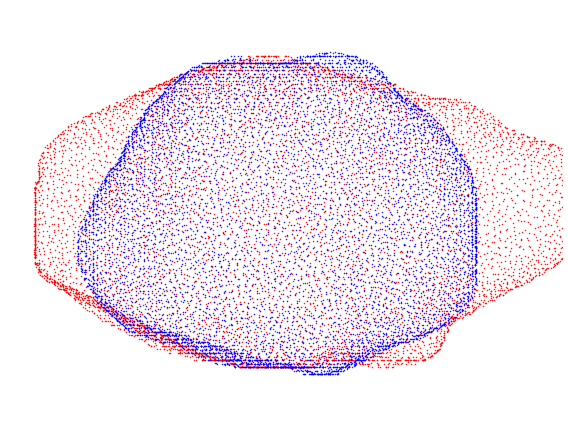

 20%|████████████████▏                                                                | 20/100 [00:10<00:37,  2.16it/s]

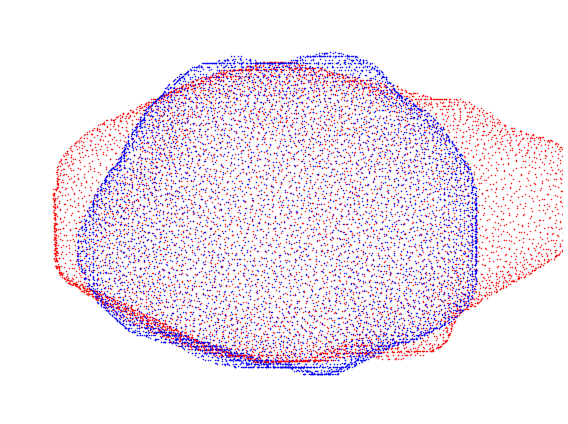

 40%|████████████████████████████████▍                                                | 40/100 [00:19<00:28,  2.12it/s]

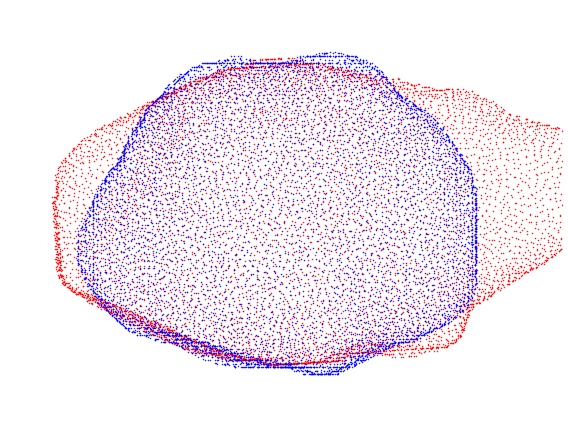

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:28<00:17,  2.23it/s]

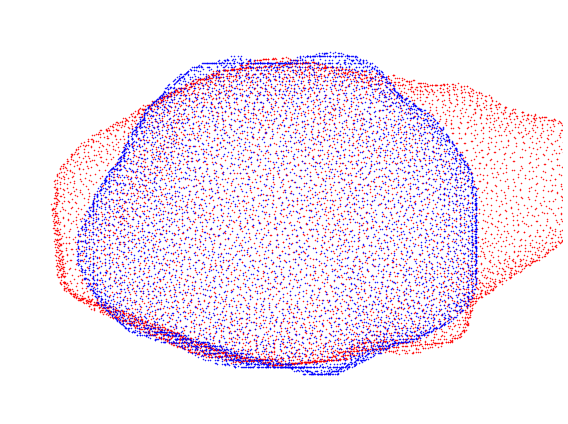

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:38<00:09,  2.14it/s]

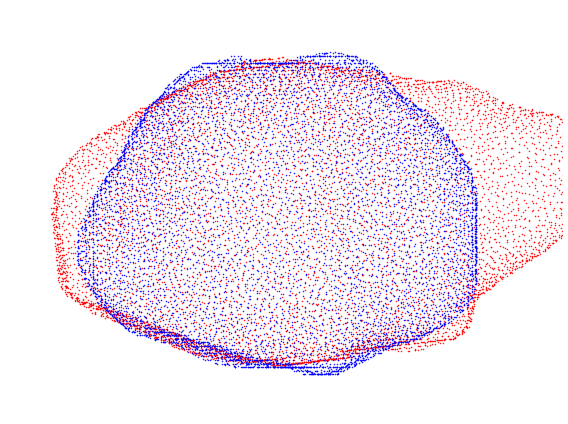

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.15it/s]

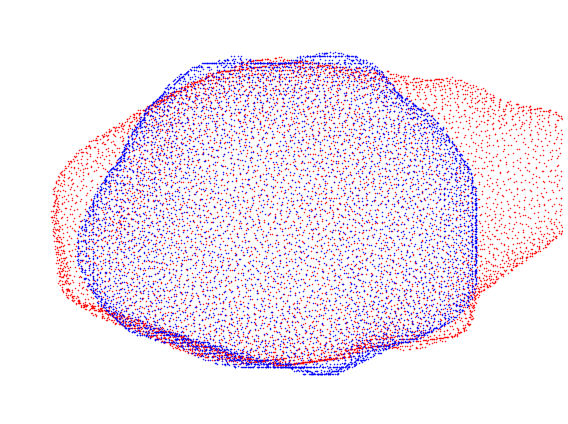

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Function 'registration_cpd'
 - Executed in 47.8430s
 - KWargs: {'tf_type_name': 'rigid', 'callbacks': [<function <lambda> at 0x0000024E5C858B80>, <lib.processing.meshing.PlotCallback object at 0x0000024E5C8BE340>], 'use_cuda': True, 'tol': 0.0005, 'maxiter': 100}


  1%|▊                                                                                 | 1/100 [00:00<01:23,  1.18it/s]

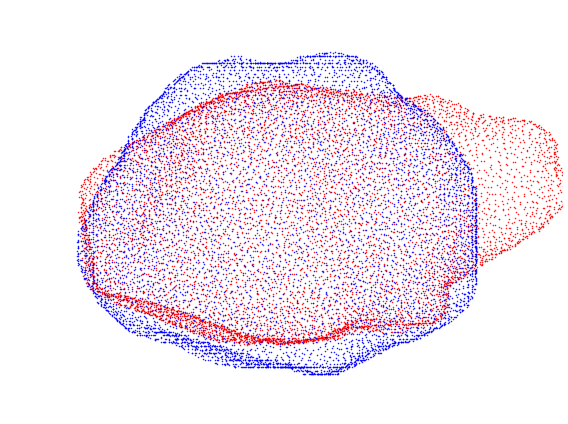

  6%|████▉                                                                             | 6/100 [00:03<01:00,  1.55it/s]

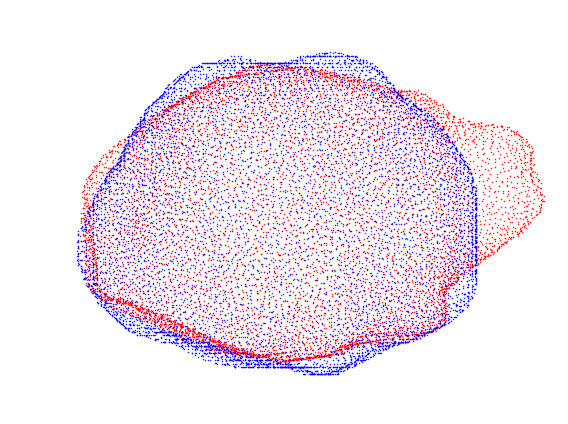

 11%|████████▉                                                                        | 11/100 [00:07<00:58,  1.51it/s]

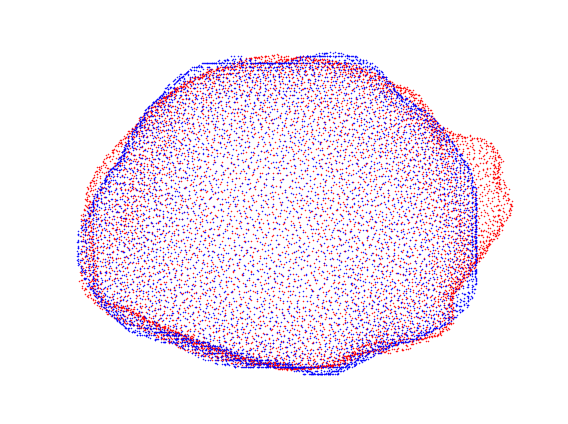

 16%|████████████▉                                                                    | 16/100 [00:10<00:54,  1.53it/s]

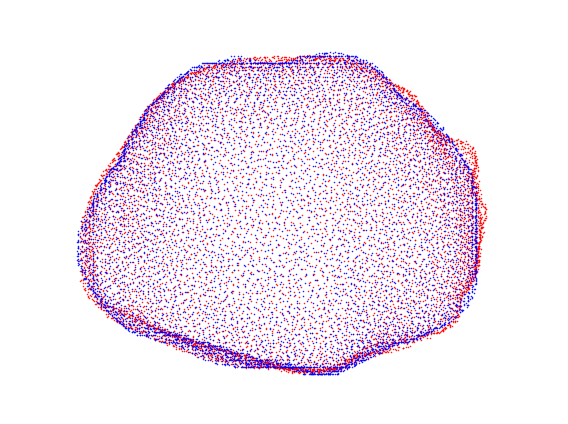

 21%|█████████████████                                                                | 21/100 [00:13<00:51,  1.54it/s]

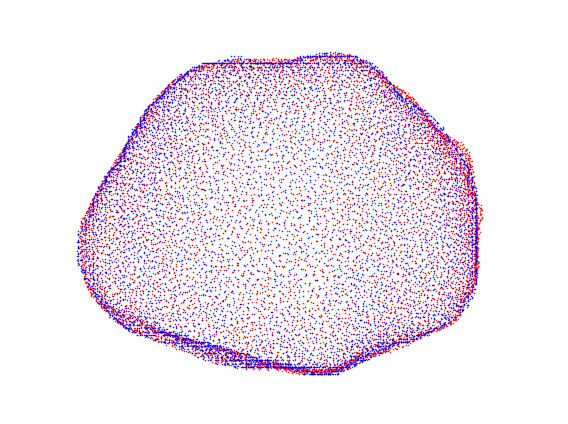

 26%|█████████████████████                                                            | 26/100 [00:17<00:47,  1.57it/s]

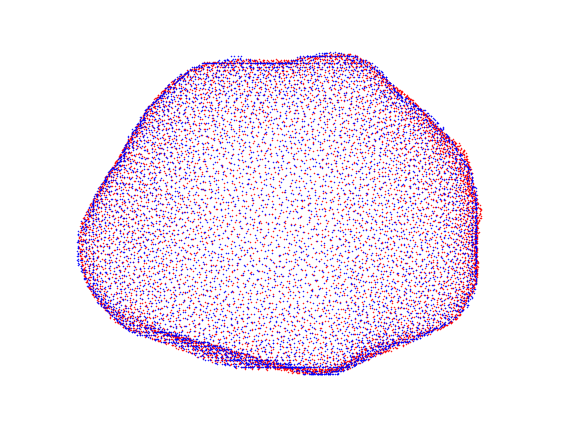

 31%|█████████████████████████                                                        | 31/100 [00:20<00:45,  1.53it/s]

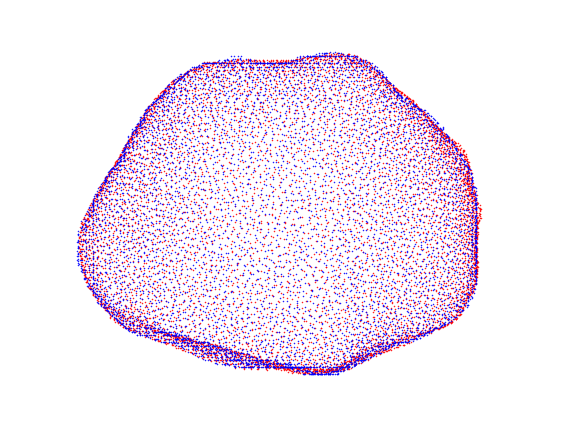

 36%|█████████████████████████████▏                                                   | 36/100 [00:23<00:41,  1.54it/s]

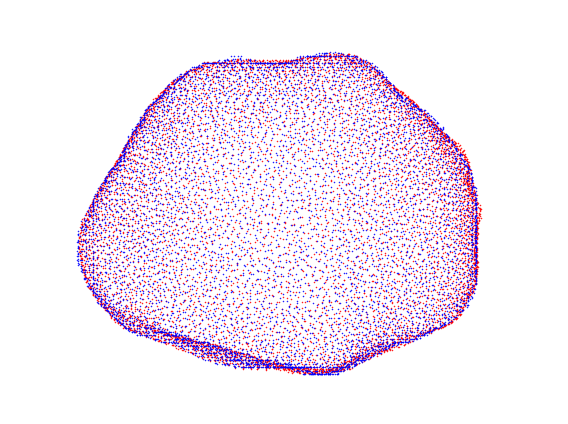

 41%|█████████████████████████████████▏                                               | 41/100 [00:26<00:38,  1.52it/s]

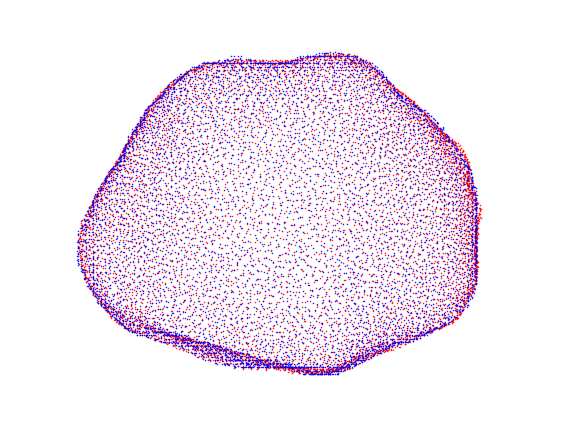

 46%|█████████████████████████████████████▎                                           | 46/100 [00:30<00:34,  1.55it/s]

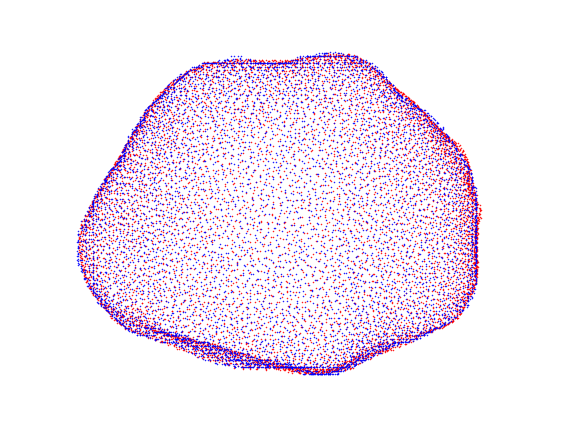

 51%|█████████████████████████████████████████▎                                       | 51/100 [00:33<00:32,  1.52it/s]

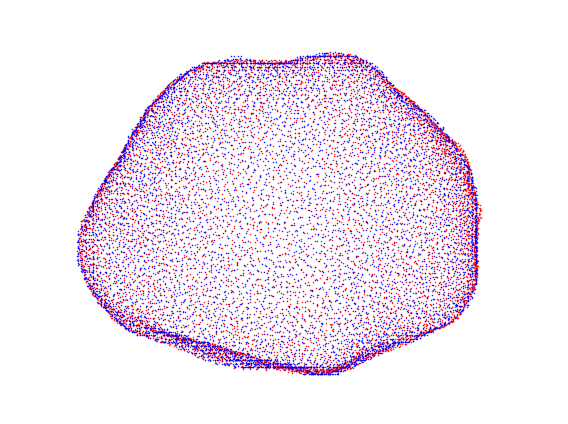

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:36<00:27,  1.57it/s]

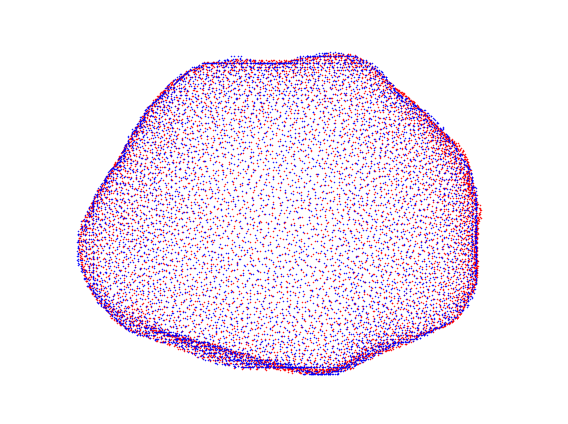

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:40<00:25,  1.52it/s]

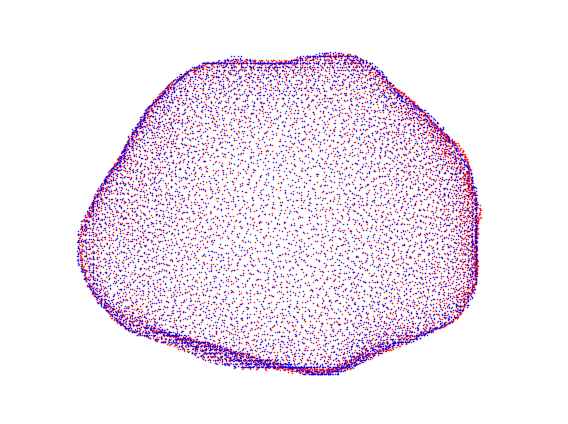

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:43<00:21,  1.57it/s]

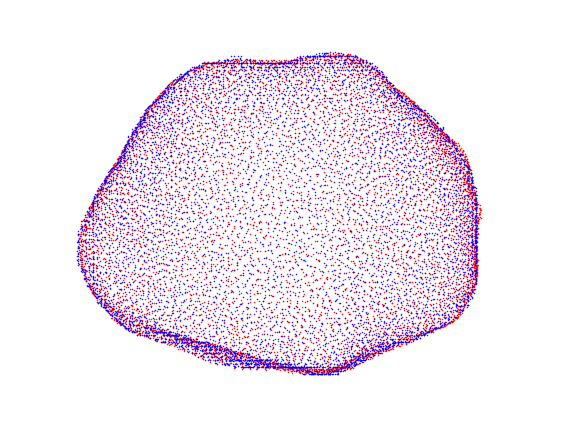

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:43<00:21,  1.52it/s]


Function 'registration_cpd'
 - Executed in 43.9710s
 - KWargs: {'callbacks': [<function <lambda> at 0x0000024E5C8DDC10>, <lib.processing.meshing.PlotCallback object at 0x0000024E5C8B5B50>], 'use_cuda': True, 'beta': 100.0, 'lmd': 3.3, 'tol': 5e-05, 'maxiter': 150, 'tf_type_name': 'nonrigid'}
Quality results:
- min_angle: min: 13.6351, median: 43.6636, max: 59.8482
- scaled_jacobian: min: 0.2722, median: 0.7972, max: 0.9985
- aspect_ratio: min: 1.0019, median: 1.2657, max: 3.4146
Simulation completed successfully!
Function 'get_DDF'
 - Executed in 13.1505s
 - KWargs: {'kernel': 'linear', 'neighbors': 10, 'epsilon': 1.0, 'smoothing': 100.0}

Metrics (>0% is better)
 - MI (all): 0: -0.0438, 1: -0.0854(94.72%)
 - MI (in): 0: -0.0141, 1: -0.0097(-31.26%)
 - MI grad (all): 0: -0.0021, 1: -0.0043(104.95%)
 - MI grad (in): 0: -0.0016, 1: -0.0012(-22.45%)
 - DSC (masks): 0: 0.8564, 1: 0.9864(15.18%)

Metrics (<0% is better)
 - HD95 (masks): 0: 8.5000, 1: 3.1623(-62.80%)
 - ABD (masks): 0: 2.674

interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

ID0002
ID0002
 - Original DSC: 0.7931


interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

Empty DataFrame
Columns: [beta, lambda, kernel, epsilon, mi_all, mi_in, mig_all, mig_in, dsc, hd95, abd, tre]
Index: []


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

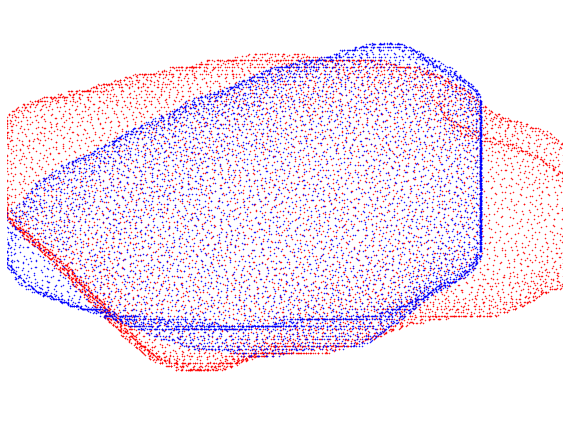

 20%|████████████████▏                                                                | 20/100 [00:11<00:46,  1.73it/s]

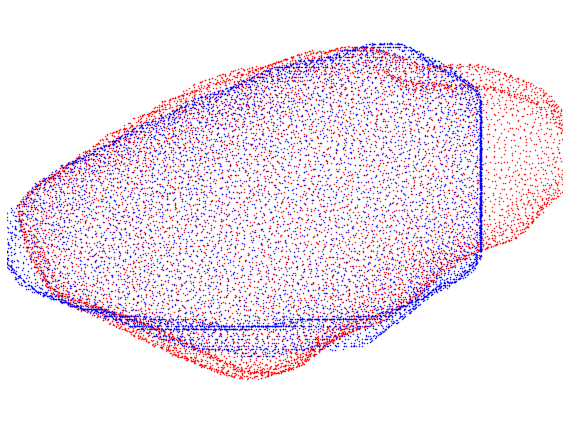

 40%|████████████████████████████████▍                                                | 40/100 [00:23<00:35,  1.70it/s]

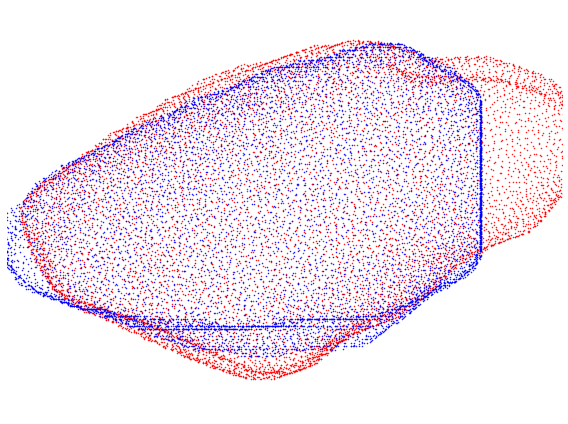

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:35<00:22,  1.77it/s]

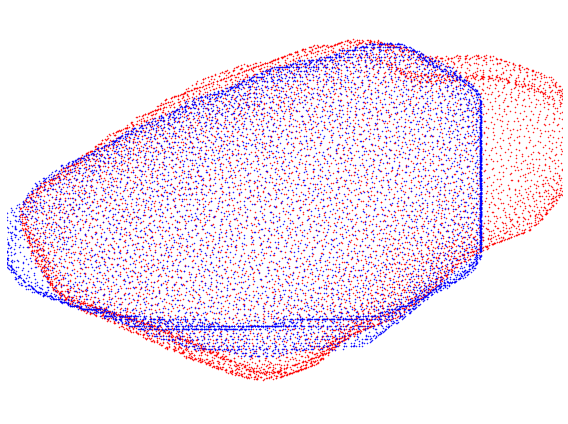

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:47<00:11,  1.70it/s]

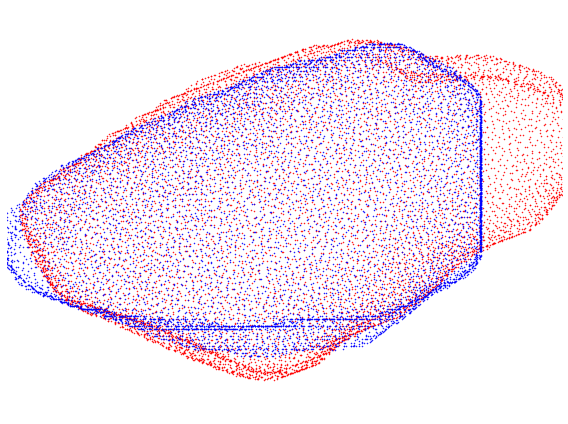

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]

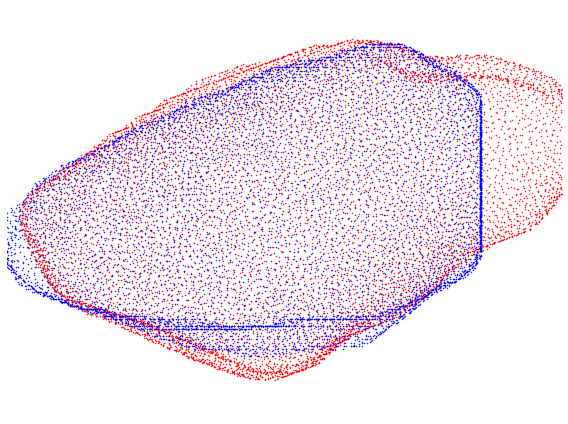

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Function 'registration_cpd'
 - Executed in 59.1900s
 - KWargs: {'tf_type_name': 'rigid', 'callbacks': [<function <lambda> at 0x0000024E09315430>, <lib.processing.meshing.PlotCallback object at 0x0000024E5973B3A0>], 'use_cuda': True, 'tol': 0.0005, 'maxiter': 100}


  1%|▊                                                                                 | 1/100 [00:00<01:22,  1.20it/s]

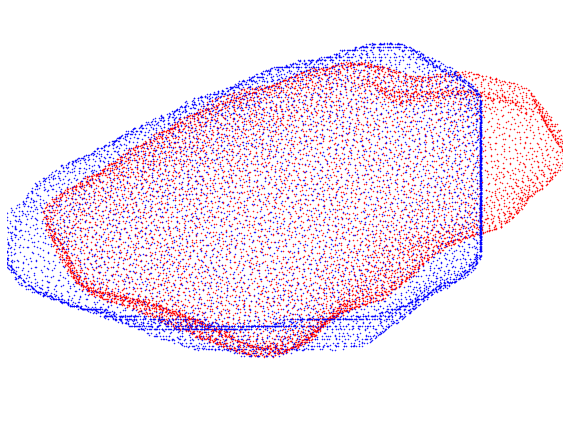

  6%|████▉                                                                             | 6/100 [00:04<01:16,  1.23it/s]

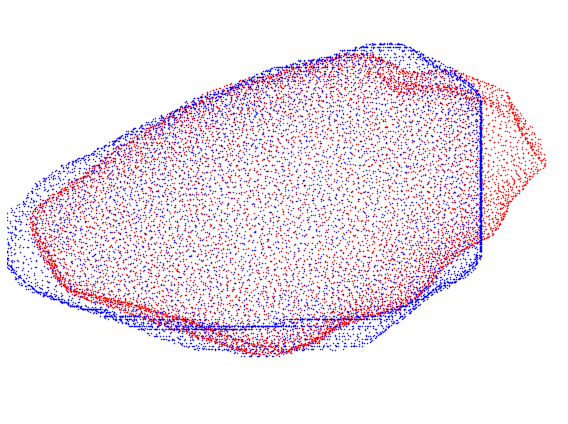

 11%|████████▉                                                                        | 11/100 [00:08<01:11,  1.25it/s]

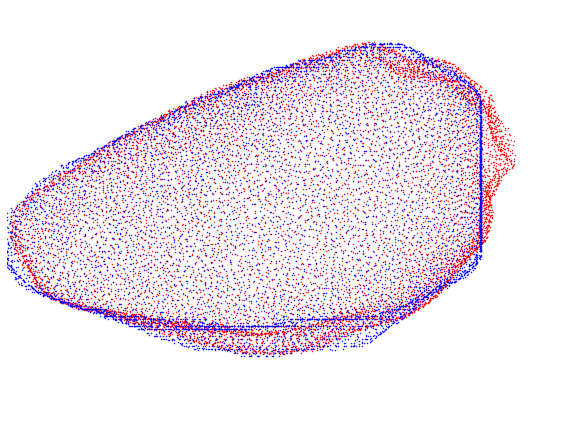

 16%|████████████▉                                                                    | 16/100 [00:12<01:07,  1.25it/s]

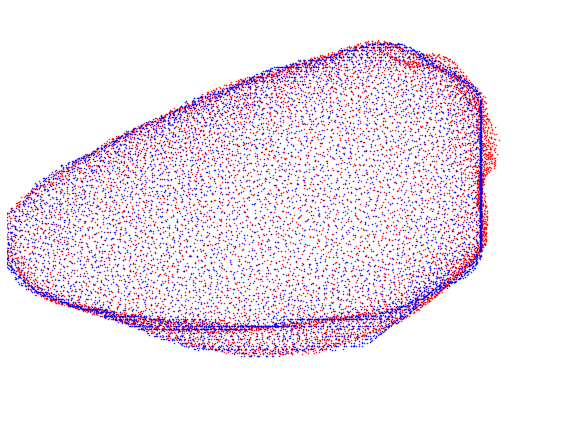

 21%|█████████████████                                                                | 21/100 [00:16<01:02,  1.26it/s]

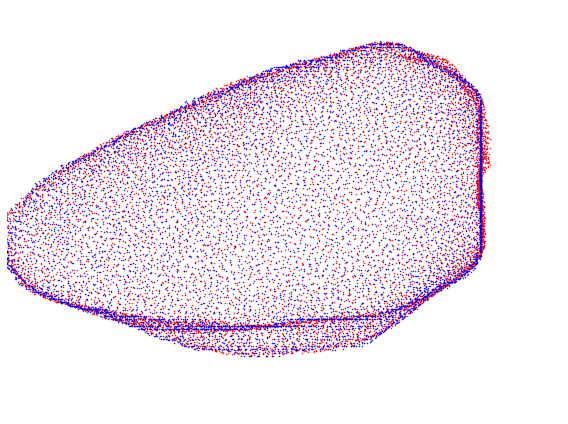

 26%|█████████████████████                                                            | 26/100 [00:20<00:58,  1.27it/s]

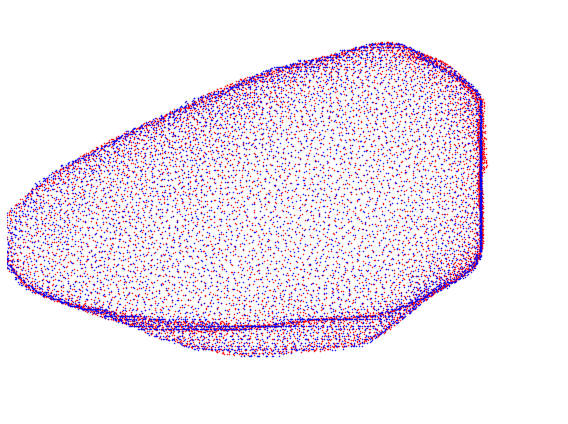

 31%|█████████████████████████                                                        | 31/100 [00:25<00:55,  1.25it/s]

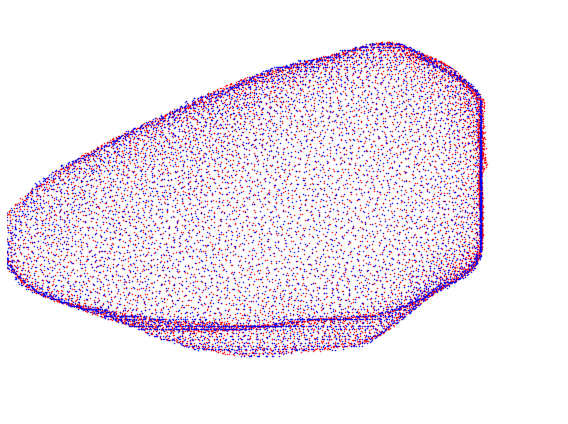

 36%|█████████████████████████████▏                                                   | 36/100 [00:29<00:51,  1.25it/s]

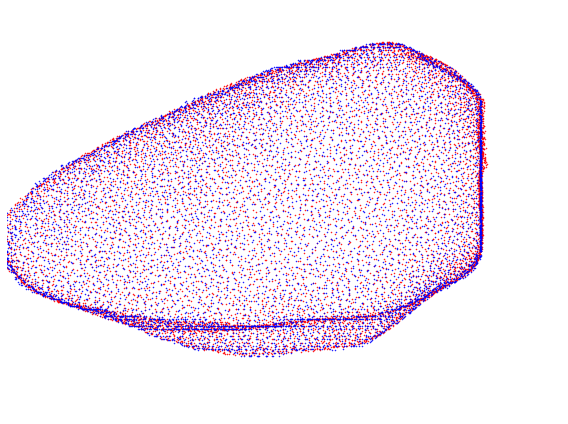

 41%|█████████████████████████████████▏                                               | 41/100 [00:33<00:47,  1.25it/s]

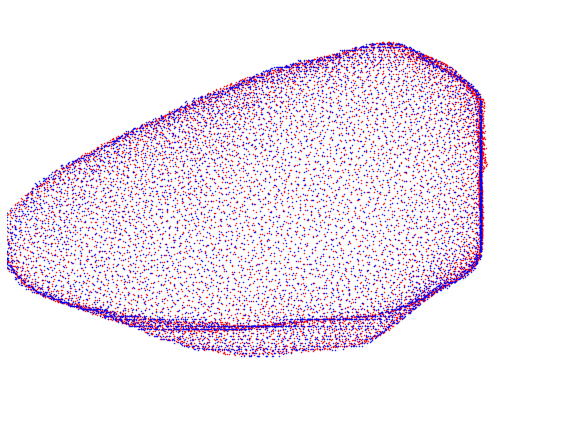

 46%|█████████████████████████████████████▎                                           | 46/100 [00:37<00:42,  1.28it/s]

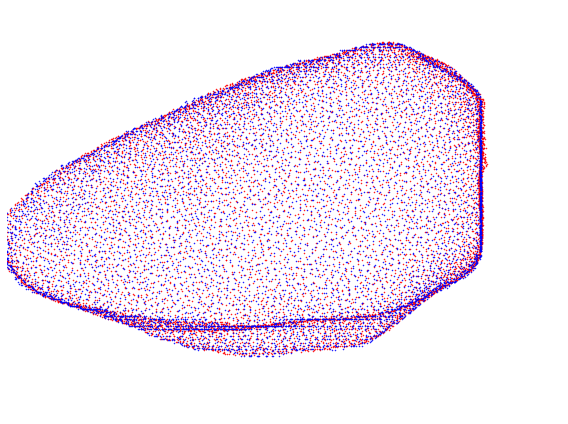

 51%|█████████████████████████████████████████▎                                       | 51/100 [00:41<00:38,  1.27it/s]

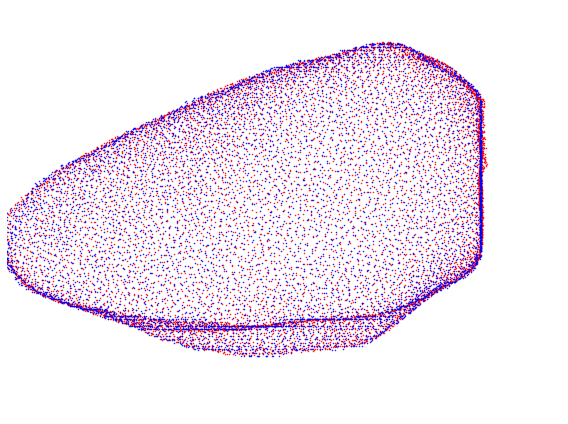

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:45<00:34,  1.26it/s]

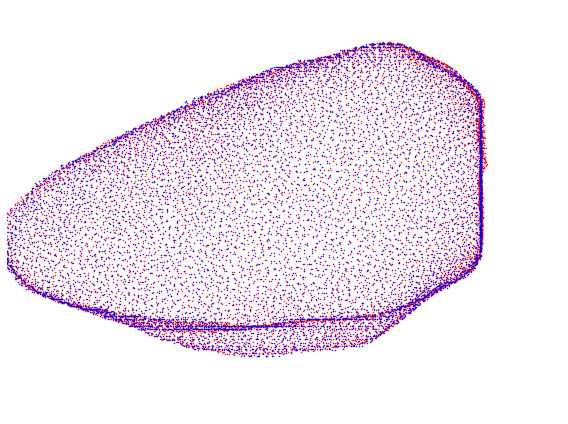

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:49<00:31,  1.25it/s]

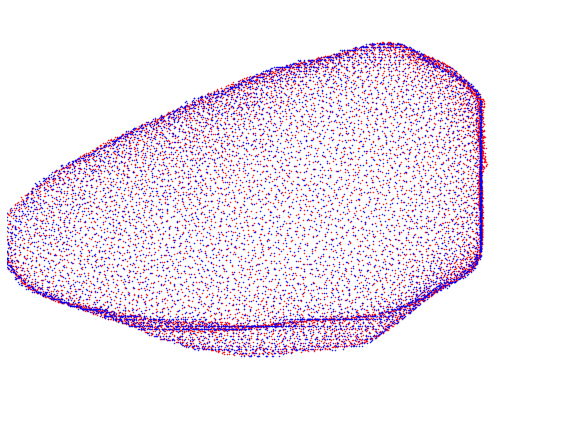

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:51<00:29,  1.24it/s]


Function 'registration_cpd'
 - Executed in 51.6194s
 - KWargs: {'callbacks': [<function <lambda> at 0x0000024F680E94C0>, <lib.processing.meshing.PlotCallback object at 0x0000024E1C662880>], 'use_cuda': True, 'beta': 100.0, 'lmd': 3.3, 'tol': 5e-05, 'maxiter': 150, 'tf_type_name': 'nonrigid'}
Quality results:
- min_angle: min: 11.7953, median: 43.2603, max: 59.8511
- scaled_jacobian: min: 0.2360, median: 0.7913, max: 0.9985
- aspect_ratio: min: 1.0021, median: 1.2730, max: 4.1171
Simulation completed successfully!
Function 'get_DDF'
 - Executed in 12.9414s
 - KWargs: {'kernel': 'linear', 'neighbors': 10, 'epsilon': 1.0, 'smoothing': 100.0}

Metrics (>0% is better)
 - MI (all): 0: -0.1211, 1: -0.1173(-3.18%)
 - MI (in): 0: -0.0130, 1: -0.0225(73.52%)
 - MI grad (all): 0: -0.0013, 1: -0.0068(411.24%)
 - MI grad (in): 0: -0.0013, 1: -0.0020(55.04%)
 - DSC (masks): 0: 0.7931, 1: 0.9690(22.18%)

Metrics (<0% is better)
 - HD95 (masks): 0: 9.5000, 1: 12.0000(26.32%)
 - ABD (masks): 0: 3.6195,

interactive(children=(IntSlider(value=80, description='z', max=159, style=SliderStyle(handle_color='lightblue'…

In [3]:
for pid in pids:
    print(pid)
    DDF_path= os.path.join(PATH_DDF, 
                   f"{pid}_DDF{'_FEM' if USE_FEM else ''}{'_linear' if 'linear' in all_kernels else ''}"
                   f"{'_linear' if 'linear' in all_kernels else ''}.nrrd")
    try:
        #Load all
        mr_img, mr_msk= sitk.ReadImage(os.path.join(PATH_OUT, pid + '_MR_img.nrrd')),\
                        sitk.ReadImage(os.path.join(PATH_OUT, pid + '_MR_msk.nrrd'))
        us_img, us_msk= sitk.ReadImage(os.path.join(PATH_OUT, pid + '_US_img.nrrd')),\
                        sitk.ReadImage(os.path.join(PATH_OUT, pid + '_US_msk.nrrd'))

        #Get to numpy
        mr_msk_arr= sitk.GetArrayFromImage(mr_msk).astype(np.uint8)
        us_msk_arr= sitk.GetArrayFromImage(us_msk).astype(np.uint8)

        #Create meshes and save
        mr_mesh_name= os.path.join(PATH_MASKS, f"{pid}_MR_msh{'_quick' if QUICK_MODE else ''}.vtk")
        us_mesh_name= os.path.join(PATH_MASKS, f"{pid}_US_msh{'_quick' if QUICK_MODE else ''}.vtk")

        if MESH_MR and not os.path.exists(mr_mesh_name):
            print('Generating:', mr_mesh_name)
            mr_mesh = timer(pygalmesh.generate_from_array)(mr_msk_arr.swapaxes(0,2), **meshing_configuration)
            print(' - MR Mesh: There are %d vertices, %d tris, and %d tetra'%(mr_mesh.points.shape[0],
                                       mr_mesh.cells_dict['triangle'].shape[0], mr_mesh.cells_dict['tetra'].shape[0]))
            mr_mesh.write(mr_mesh_name)
            mr_mesh.write(mr_mesh_name.replace('.vtk', '.inp'))
        else:
            mr_mesh= meshio.read(mr_mesh_name)

        if MESH_US and not os.path.exists(us_mesh_name):
            us_mesh = timer(pygalmesh.generate_from_array)(us_msk_arr.swapaxes(0,2), **meshing_configuration)
            print(' - US Mesh: There are %d vertices, %d tris, and %d tetra'%(us_mesh.points.shape[0],
                                       us_mesh.cells_dict['triangle'].shape[0], us_mesh.cells_dict['tetra'].shape[0]))
            us_mesh.write(us_mesh_name)
            us_mesh.write(us_mesh_name.replace('.vtk', '.inp'))
        else:
            us_mesh= meshio.read(us_mesh_name)

        #Save mesh statistics
        mr_tris.append( mr_mesh.cells_dict['triangle'].shape[0] )
        mr_tetras.append( mr_mesh.cells_dict['tetra'].shape[0] )
        mr_surface_vertices.append( len(np.unique(mr_mesh.cells_dict['triangle'].flatten())) )
        
        us_tris.append( us_mesh.cells_dict['triangle'].shape[0] )
        us_tetras.append( us_mesh.cells_dict['tetra'].shape[0] )
        us_surface_vertices.append( len(np.unique(us_mesh.cells_dict['triangle'].flatten())) )

        #Re-read them in pyvista format: 
        mr_mesh_pv = pv.read(mr_mesh_name)
        us_mesh_pv = pv.read(us_mesh_name)

        #Load fiducials (if available)
        mr_fiducials= read_fiducials(os.path.join(PATH_FID, pid + '_MR.mrk.json'))
        us_fiducials= read_fiducials(os.path.join(PATH_FID, pid + '_US.mrk.json'), check_fiducials=mr_fiducials)
        us_fiducials= list(us_fiducials.values())
        mr_fiducials= list(mr_fiducials.values()) if len(us_fiducials) else []

        #Plot
        if PLOT:
            print(pid)
            print(' - Original DSC: %.4f'%DSC_sitk(mr_msk, us_msk))
            plot(mr_img, masks=[mr_msk, ], hide_axis=True,
                 points= [[*mr_img.TransformPhysicalPointToContinuousIndex(p), 'o', 'tab:blue']\
                              for i,p in enumerate(mr_fiducials)])
            plot(us_img, masks=[ us_msk], hide_axis=True,
                 points= [[*us_img.TransformPhysicalPointToContinuousIndex(p), 'o', 'tab:blue']\
                              for i,p in enumerate(us_fiducials)])

        #Perform registration -------------------------------------------------------------------------------------
        #Create results df
        results_df= pd.DataFrame(columns=columns)

        #Get surface meshes from the volumetric meshes
        surf_points_i_mr, surf_points_mr, surf_mesh_pv_mr= get_surface_mesh(mr_mesh)
        surf_points_i_us, surf_points_us, surf_mesh_pv_us= get_surface_mesh(us_mesh)

        #Get a point cloud from the surface mesh
        source_mesh= o3.geometry.PointCloud(o3.utility.Vector3dVector(surf_points_mr))
        target_mesh= o3.geometry.PointCloud(o3.utility.Vector3dVector(surf_points_us))

        #Get points into GPU / CPU
        source_pt = to_array(source_mesh.points, dtype=float32) #MR
        target_pt = to_array(target_mesh.points, dtype=float32) #US

        class IdentityTransform(): transform= lambda self, a: a #Just for plotting before CPD
        min_p, max_p= np.min(source_mesh.points, axis=0) - 7, np.max(source_mesh.points, axis=0) + 7
        plot_params= dict(to_numpy=to_numpy, x_limits=[min_p[0], max_p[0]], y_limits=[min_p[1], max_p[1]],
                          size=(8,6), hide_axis=True, mode='2d', axis=[2,1,0], 
                          moving_last_N= 0, fixed_last_N=0)
        reg_kwargs= dict(tf_type_name='nonrigid')
        print(results_df)
        
        #Make loops to sweep hyperparameters if needed
        for beta in betas:
            for lmd in lambdas:
                if REGISTER_RIGID:
                    with tqdm(total=100, position=0, leave=True) as pbar:
                        plot_callback= PlotCallback(source_pt, target_pt, plot_interval=20, **plot_params)
                        plot_callback(IdentityTransform())
                        tf_param, a, b = timer(cpd.registration_cpd)(source_pt, target_pt, tf_type_name='rigid', 
                                                              callbacks=[lambda _: pbar.update(1), plot_callback],
                                                              use_cuda=USE_CUDA, tol=5e-4 , maxiter=100)
                    source_pt_init= tf_param.transform(source_pt)
                    with tqdm(total=100, position=0, leave=True) as pbar:
                        plot_callback= PlotCallback(source_pt_init, target_pt, plot_interval=5, **plot_params)
                        tf_param2, a, b = timer(cpd.registration_cpd)(source_pt_init, target_pt,
                                                              callbacks=[lambda _: pbar.update(1), plot_callback],
                                                              use_cuda=USE_CUDA, beta=beta, lmd=lmd, 
                                                              tol=5e-5 , maxiter=150, **reg_kwargs)
                    source_pt_after= tf_param2.transform(source_pt_init)

                else:           
                    source_pt_init= source_pt
                    with tqdm(total=100, position=0, leave=True) as pbar:
                        plot_callback= PlotCallback(source_pt_init, target_pt, plot_interval=5, **plot_params)
                        plot_callback(IdentityTransform())
                        tf_param, a, b = timer(cpd.registration_cpd)(source_pt_init, target_pt, 
                                                              callbacks=[lambda _: pbar.update(1), plot_callback],
                                                              use_cuda=USE_CUDA, beta=beta, lmd=lmd,
                                                              tol=5e-4 , maxiter=150, **reg_kwargs)         
                        source_pt_after= tf_param.transform(source_pt_init)

                #Apply registration
                surf_mesh_pv_mr_after= copy.deepcopy(surf_mesh_pv_mr)
                pt_mr_after_cpu= to_cpu(source_pt_after)
                surf_mesh_pv_mr_after.points= pt_mr_after_cpu
                quality(surf_mesh_pv_mr_after, plot=False)

                #Get surface points and CPD-found deformations
                surf_pts= to_numpy(surf_mesh_pv_mr.points)
                surf_def= to_numpy(surf_mesh_pv_mr_after.points - surf_mesh_pv_mr.points)

                #Make loops to sweep hyperparameters if needed
                for kernel in all_kernels:
                    for epsilon in epsilons:
                        #Predict the DDF by interpolating from the known surface points
                        #This is a slow process, taking around 40s-80s for an 8-core processor
                        USE_EPSILON= kernel not in ['thin_plate_spline', 'linear', 'cubic']
                        if USE_FEM:
                            fem_displacements= get_FEM_displacements(mr_mesh, surf_points_i_mr, surf_def, 
                                                                     time_steps=5, **fem_material)
                            DDF_tfm= timer(get_DDF)(mr_mesh.points, fem_displacements, mr_img.GetSize(), mr_img.GetSpacing(), 
                                                    kernel='linear', neighbors=10,
                                                    epsilon=epsilon if USE_EPSILON else 1.,
                                                    smoothing=epsilon if not USE_EPSILON else 0.)
                        else:
                            DDF_tfm= timer(get_DDF)(surf_pts, surf_def, mr_img.GetSize(), mr_img.GetSpacing(), kernel=kernel,
                                                    epsilon=epsilon if USE_EPSILON else 1.,
                                                    smoothing=epsilon if not USE_EPSILON else 0.)

                        #Obtain reverse transformation
                        DDF_tfm_img= sitk.DisplacementFieldTransform(sitk.InvertDisplacementField(
                                            DDF_tfm.GetDisplacementField(), enforceBoundaryCondition=False, ))

                        #Apply transformation to the points and to the original image
                        mr_img_after= transform_sitk(mr_img, DDF_tfm_img, sitk.sitkBSpline)
                        mr_msk_after= transform_sitk(mr_msk, DDF_tfm_img, sitk.sitkLabelGaussian)
                        mr_fiducials_after= list(sitk_transform_points(DDF_tfm, mr_fiducials)) if len(mr_fiducials) else []

                        #plot and obtain some performance metrics
                        print('\nMetrics (>0% is better)')
                        mi_all= print_metric(us_img, mr_img, mr_img_after, metric=MI_sitk, name='MI (all)')[1]
                        mi_in= print_metric(us_img, mr_img, mr_img_after, 
                                            metric=partial(MI_sitk, mask=us_msk), name='MI (in)')[1]
                        mig_all= print_metric(us_img, mr_img, mr_img_after, metric=lambda *args:  
                            MI_sitk(*(get_gradient_features(a) for a in args)), name='MI grad (all)')[1]
                        mig_in= print_metric(us_img, mr_img, mr_img_after, metric=lambda *args: 
                                             MI_sitk(*(get_gradient_features(a) for a in args), mask=us_msk), name='MI grad (in)')[1]
                        dsc= print_metric(us_msk, mr_msk, mr_msk_after, metric=DSC_sitk, name='DSC (masks)')[1]
                        print('\nMetrics (<0% is better)')
                        hd95= print_metric(us_msk, mr_msk, mr_msk_after, 
                            metric=lambda *i: surface_distance_metrics(*i)[0], name='HD95 (masks)')[1]
                        abd= print_metric(us_msk, mr_msk, mr_msk_after, 
                            metric=lambda *i: surface_distance_metrics(*i)[1], name='ABD (masks)')[1]
                        tre= print_metric(us_fiducials, mr_fiducials, mr_fiducials_after, 
                                          metric=point_average_error, name='TRE (mm)')[1]

                        #Update dataframe
                        results_df= results_df.append(dict(zip(columns, [beta, lmd, kernel, epsilon, mi_all, mi_in,
                                                     mig_all, mig_in, dsc, hd95, abd, tre])), ignore_index=True)

                        #Plot everything
                        plot(mr_img_after, allowed_label_overlap=[3,3], text_kwargs=dict(size=14), scale= 3, 
                             masks=[ [msk, [1], [color], [name]] for msk, name, color in zip([us_msk, mr_msk, mr_msk_after], 
                                     ['US', 'MR before', 'MR after'], ['tab:blue', 'tab:red', 'tab:orange']) ],
                             points=[[*us_img.TransformPhysicalPointToContinuousIndex(p),'o','tab:blue',f'{i+1} (US)']\
                                         for i,p in enumerate(us_fiducials)] +
                                    [[*mr_img_after.TransformPhysicalPointToContinuousIndex(p),'o','tab:red',f'{i+1} (MR after)']\
                                         for i,p in enumerate(mr_fiducials_after) ] )

                        #Save!
                        if SAVE: sitk.WriteImage(DDF_tfm.GetDisplacementField(), DDF_path, True, -1)
    except Exception as e:
        print(' > There was a problem:', e)

In [4]:
#Statistics
print('MR Tris', np.mean(mr_tris), 'Tetras',  np.mean(mr_tetras), 'Surface vertices', np.mean(mr_surface_vertices))
print('US Tris', np.mean(us_tris), 'Tetras',  np.mean(us_tetras), 'Surface vertices', np.mean(us_surface_vertices))

print('Tris', np.std(mr_tris), 'Tetras', np.std(mr_tetras),  'Surface vertices', np.std(mr_surface_vertices))
print('Tris', np.std(us_tris), 'Tetras', np.std(us_tetras),  'Surface vertices', np.std(us_surface_vertices))

#Hyperparameter sweep results
results_df

MR Tris 33826.0 Tetras 364723.0 Surface vertices 8459.5
US Tris 30334.0 Tetras 318799.5 Surface vertices 7585.5
Tris 1654.0 Tetras 23121.0 Surface vertices 413.5
Tris 1214.0 Tetras 4531.5 Surface vertices 303.5


beta  lambda             kernel  epsilon    mi_all     mi_in   mig_all  \
0  100.0     3.3  thin_plate_spline    100.0 -0.117284 -0.022485 -0.006815   

     mig_in       dsc  hd95       abd       tre  
0 -0.001976  0.969002  12.0  1.840441  6.144955

In [5]:
#We can also view the mesh in 3D directly in the Notebook
view(geometries=[mr_mesh_pv, us_mesh_pv])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…